1. 데이터셋 이미지 크기
2. training

import

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from PIL import Image
import cv2

import torch
from torch import nn
from torch.functional import F
import torchvision
from torchvision import transforms

from importlib import reload

import cambridge
reload(cambridge)

import models.posenet
reload(models.posenet)

import criterion
reload(criterion)

<module 'criterion' from 'c:\\Users\\82105\\Desktop\\PoseNet\\PoseNet\\criterion.py'>

cuda or cpu

In [2]:
# cuda or mps
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"using {device} device")

using cpu device


dataset

In [3]:
image_height = 360
image_width = 480

# basic transform
transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# load dataset
dataset_root = '/Users/82105/Desktop/sample'
train_set = cambridge.CambridgeDataset(dataset_root, 'train', transform=transform)

# split train and val set
split_ratio = 0.5
seed = 42
torch.manual_seed(seed)
train_set, val_set = torch.utils.data.random_split(train_set, 
                                                   [int(len(train_set)*split_ratio), 
                                                    len(train_set)-int(len(train_set)*split_ratio)])

test_set = cambridge.CambridgeDataset(dataset_root, 'test', transform=transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


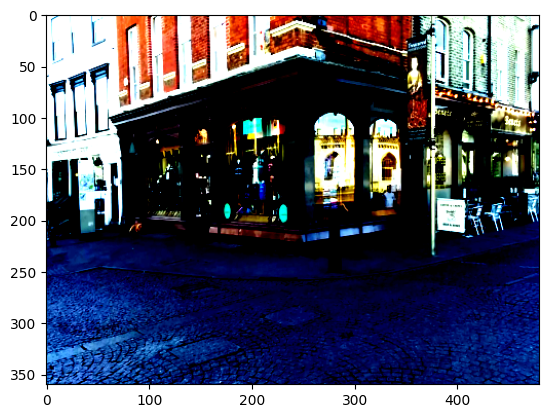

In [4]:
image, tr, rot  = train_set[0]
# visualize image
plt.imshow(image.permute(1, 2, 0))
plt.show()

data loader

In [5]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

model

In [6]:
# mobile
model = models.posenet.PoseNet().to(device) # input size: 360x480

training

In [7]:
# logger
class AverageMeter():
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 2

mobil

In [9]:
loss_meter = AverageMeter()

train_losses = []
val_losses = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):

    for param_group in optimizer.param_groups:
        print('learing rage: ', param_group['lr'])

    # train
    model.train()
    print ('------------------- Train: Epoch [{}/{}] -------------------'.format(\
        epoch+1, num_epochs) )

    loss_meter.reset()

    for i, [X, tr,rot] in enumerate(train_loader):
        X = X.to(device)
        tr = tr.to(device)
        rot = rot.to(device)

        # Forward pass
        pred_tr, pred_rot = model(X)
        loss, tr_loss, rot_loss = criterion.compute_pose_loss(pred_tr, pred_rot, tr, rot)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # logging
        loss_meter.update(loss.item(), X.size()[0] )

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(\
                epoch+1, num_epochs, i+1, total_step, loss_meter.avg) )

    print ('==> Train loss: {:.4f}'.format(loss_meter.avg) )
    train_losses.append(loss_meter.avg)

    # val
    model.eval()
    print ('------------------- Val.: Epoch [{}/{}] -------------------'.format(\
        epoch+1, num_epochs) )

    loss_meter.reset()

    for i, [X, tr,rot] in enumerate(val_loader):
        X = X.to(device)
        tr = tr.to(device)
        rot = rot.to(device)

        # Forward pass
        pred_tr, pred_rot = model(X)
        loss, tr_loss, rot_loss = criterion.compute_pose_loss(pred_tr, pred_rot, tr, rot)

        # logging
        loss_meter.update(loss.item(), X.size()[0] )

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(\
                epoch+1, num_epochs, i+1, total_step, loss_meter.avg) )

    print ('==> Val. loss: {:.4f}'.format(loss_meter.avg) )
    val_losses.append(loss_meter.avg)

learing rage:  1e-05
------------------- Train: Epoch [1/2] -------------------
==> Train loss: 181.4047
------------------- Val.: Epoch [1/2] -------------------
==> Val. loss: 75.9054
learing rage:  1e-05
------------------- Train: Epoch [2/2] -------------------
==> Train loss: 71.3063
------------------- Val.: Epoch [2/2] -------------------
==> Val. loss: 64.9999
